# t-SNE
t-Distributed Stochastic Neighbor Embedding (t-SNE)

Buen vídeo básico de introducción al t-SNE
https://www.youtube.com/watch?v=NEaUSP4YerM

https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1



##  t-SNE

Para probar el método, vamos a crear un *dataset* formado por **tres grupos** de puntos generados con distintas localizaciones y varianzas.

In [1]:
import numpy as np
import pandas as pd

C1 = np.random.normal(loc=0., scale=1., size=(10,3))
I1 = np.ones(10, dtype=int)

#C2 = np.random.normal(loc=2., scale=0.1, size=(10,3))
C2 = np.random.normal(loc=5., scale=1., size=(10,3))
I2 = np.ones(10, dtype=int)*2

#C3 = np.random.normal(loc=5, scale=2, size=(10,3))
C3 = np.random.normal(loc=10, scale=1., size=(10,3))
I3 = np.ones(10, dtype=int)*3


df1 = pd.DataFrame(data=C1, columns=["x", "y", "z"])
df1I = pd.DataFrame(data=I1, columns=["class"])

df2 = pd.DataFrame(data=C2, columns=["x", "y", "z"])
df2I = pd.DataFrame(data=I2, columns=["class"])

df3 = pd.DataFrame(data=C3, columns=["x", "y", "z"])
df3I = pd.DataFrame(data=I3, columns=["class"])


result1 = pd.concat([df1, df1I], axis = 1, ignore_index=True, sort=False)
result2 = pd.concat([df2, df2I], axis = 1, ignore_index=True, sort=False)
result3 = pd.concat([df3, df3I], axis = 1, ignore_index=True, sort=False)

df = pd.concat([result1, result2, result3])
df.columns = ["x","y", "z","class"]
df = df.reset_index(drop=True)

Veamos los puntos de forma tabulada.


In [2]:
df

,x,y,z,class
0,1.558439,-1.017799,0.655407,1
1,0.411321,-0.151995,0.994921,1
2,-1.030130,-0.434505,0.161757,1
3,0.248115,-0.148245,-0.813225,1
4,0.169383,-0.818551,-0.934284,1
5,2.261929,-1.305265,0.404547,1
6,1.542246,0.712254,0.583826,1
7,0.472664,-1.400618,0.315707,1
8,-0.619033,0.685972,0.282687,1
9,0.049339,0.102996,-0.467179,1


Visualicemos el conjunto de puntos tridimensional:

In [67]:
import plotly.express as px
import matplotlib.pyplot as plt

fig = px.scatter_3d(df, x="x", y="y", z="z", color="class")
fig.show()

<code>Q_points</code> será nuestro conjunto de puntos tridimensionales y <code>P_points</code> será nuestro conjunto de puntos bidimensionales con los que intentaremos visualizar el primer conjunto.

In [2]:
Q_points = df.values[:,0:3]  # Tomamos las coordenadas de los puntos, no la clase
P_points = np.random.uniform(0, 10, size=(30,2))  # Generamos puntos al azar

Si visualizamos el conjunto de puntos bidimensional, veremos que está totalmente desordenado (está generado al azar).

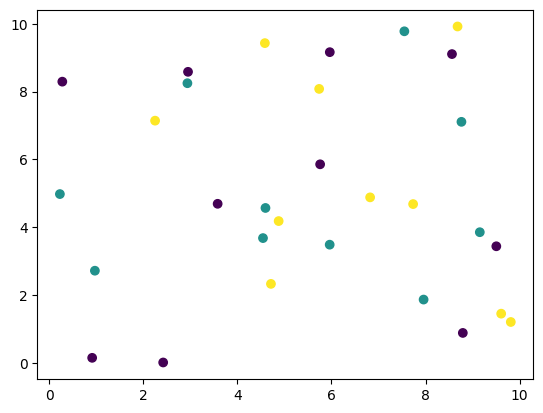

In [3]:
import matplotlib.pyplot as plt

P_index = np.concatenate((np.ones(10, dtype=int), np.ones(10, dtype=int)*2, np.ones(10, dtype=int)*3))
plt.scatter(P_points[:,0], P_points[:,1], c=P_index)

Antes de seguir vamos a echarle un vistazo a las matrices de distancia.

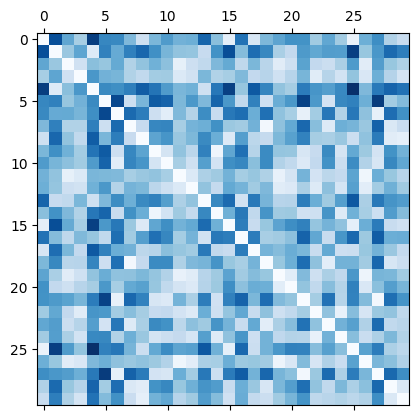

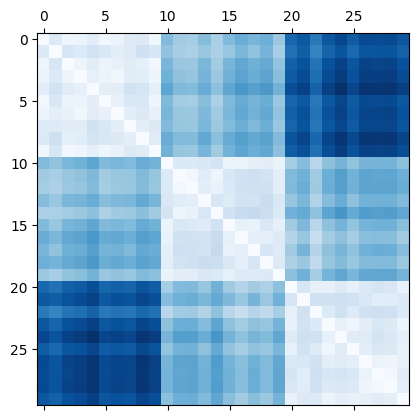

In [4]:
PM = np.zeros((30,30))
QM = np.zeros((30,30))

def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

for i, p in enumerate(P_points):
    PM[i] = [distance(p, j) for j in P_points]
    
for i, q in enumerate(Q_points):
    QM[i] = [distance(q, j) for j in Q_points]
      
plt.matshow(PM, cmap=plt.cm.Blues)  # Representamos la matriz P
plt.matshow(QM, cmap=plt.cm.Blues)  # Representamos la matriz Q

Ahora nos hace falta definir una función para calcular la distancia entre puntos, otra para obtener la **función de distribución de probabilidad** y una última para calcular la divergencia de **Kullback-Leibler**.

In [5]:
import torch
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'

distT_torch = torch.distributions.studentT.StudentT(df=1, loc=0, scale=1)

def distance(p1, p2):
    return torch.sqrt(torch.sum((p1 - p2)**2) + 1e-6)
    
def pdf(x):
    return torch.exp(distT_torch.log_prob(x))

def KL(p, q):
    return torch.where(q > 0.1e-8, p * torch.log(p/q), torch.tensor([0.], dtype=torch.double, device=device)).sum()
    

Pasamos los puntos creados en Numpy a tensores de PyTorch <code>P</code> y <code>Q</code>. Los puntos <code>P</code> son los que tenemos que "mover", por eso requieren gradiente.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

P = torch.tensor(P_points, requires_grad=True, dtype=torch.float, device=device)
Q = torch.tensor(Q_points, dtype=torch.float, device=device)

In [7]:
optimizer = torch.optim.RMSprop([P], lr=0.1)

epochs = 500

for k in range(epochs):
    
    PM = torch.tensor(np.zeros((len(P_points), len(P_points))), dtype=float, device=device)
    QM = torch.tensor(np.zeros((len(P_points), len(P_points))), dtype=float, device=device)
    
    for i, q_row in enumerate(Q):
        for j, q_column in enumerate(Q):
            QM[i, j] = distance(q_row, q_column)
    
    QD = pdf(QM)
    QD = torch.div(QD.t(), torch.sum(QD, dim=1)).t()
        
    for i, p in enumerate(P):
        for j, q in enumerate(P):
            PM[i, j] = distance(p, q)

    PD = pdf(PM)
    PD = torch.div(PD.t(), torch.sum(PD, dim=1)).t()
        
    loss = torch.tensor([0.], device=device)
    for pd, qd in zip(PD, QD):
        loss += KL(pd, qd)
    
    if k%10 == 0:
        print("Epoch:", k, "loss:", loss.item())
    

    loss.backward()   
    optimizer.step()    
    optimizer.zero_grad()

KeyboardInterrupt: 

Visualizamos el resultado:

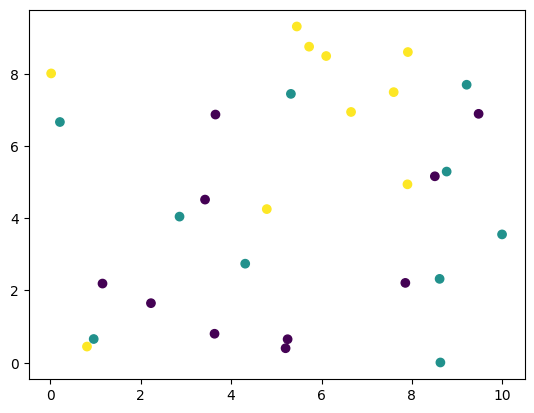

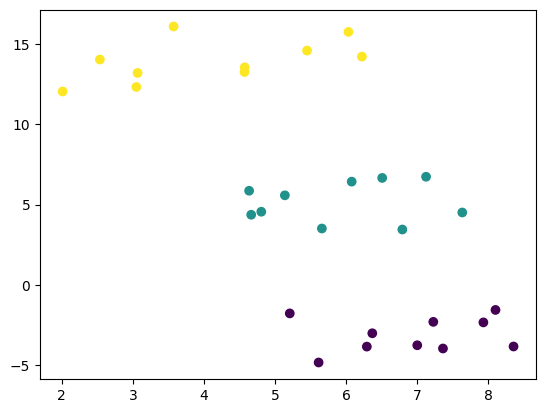

In [80]:
import matplotlib.pyplot as plt

final_points = P.cpu().detach().numpy()
P_index = np.concatenate((np.ones(10, dtype=int), np.ones(10, dtype=int)*2, np.ones(10, dtype=int)*3))


plt.scatter(P_points[:,0], P_points[:,1], c=P_index)
plt.show()

plt.scatter(final_points[:,0], final_points[:,1], c=P_index)

## Ejercicios

1. Crea el conjunto tridimensional anterior con tres clases con el mismo centro y dispersión. De esa forma, las clases serán no separables. Mira a ver qué ocurre con su visualización con t-SNE.

2. Calcula la visualización t-SNE usando el conjunto de datos IRIS.